# Resnet50 trainable (conv5_block1_1_conv) ~ True

In [1]:
import os
import numpy as np
import tensorflow as tf

# gpu 문제로 코드가 안돌아가는 상황이 있어서 set_memory_growth 셋팅을 설정해준 코드
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        logical_gpus = tf.config.experimental.list_logical_devices('GPU')
        print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
    except RuntimeError as e:
        print(e)

1 Physical GPUs, 1 Logical GPUs


In [2]:
data_path = "food_data"
train_path = os.path.join(data_path, 'train')
val_path = os.path.join(data_path, 'val')
test_path = os.path.join(data_path, 'test')

In [3]:
train_len = 0
for i in os.listdir(train_path):
    train_len += len(os.listdir( os.path.join( train_path, i) ))

val_len = 0
for i in os.listdir(val_path):
    val_len += len(os.listdir( os.path.join( val_path, i) ))

test_len = 0
for i in os.listdir(test_path):
    test_len += len(os.listdir( os.path.join( test_path, i) ))

print(f"train : {train_len}, val : {val_len}, test : {test_len}")

train : 5250, val : 1750, test : 1750


In [4]:
# ImageDataGenerator를 통해 이미지를 원하는 shape으로 불러오고 augmentation 해줄 수 있음
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# 데이터 0~1 정규화
data_gen = ImageDataGenerator(rescale=1./255)

# flow_from_directory를 통해서 폴더에 분류 있는 데이터들을 레이블과 함께 얻어올 수 있음
train_data = data_gen.flow_from_directory(
    train_path, class_mode='categorical', color_mode='rgb',
    shuffle=True, target_size=(200,200), batch_size=50 # 5250
)
val_data = data_gen.flow_from_directory(
    val_path, class_mode='categorical', color_mode='rgb',
    shuffle=True, target_size=(200,200), batch_size=50 # 1750
)
test_data = data_gen.flow_from_directory(
    test_path, class_mode='categorical', color_mode='rgb',
    shuffle=True, target_size=(200,200), batch_size=50 # 1750
)

Found 5250 images belonging to 35 classes.
Found 1750 images belonging to 35 classes.
Found 1750 images belonging to 35 classes.


In [5]:
from tensorflow.keras.applications.resnet import ResNet50
resnet_model = ResNet50(
    weights='imagenet',
    include_top=False,
    input_shape=(200,200,3)
)

In [6]:
resnet_model.summary()

Model: "resnet50"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 200, 200, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 206, 206, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 100, 100, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 100, 100, 64) 256         conv1_conv[0][0]                 
___________________________________________________________________________________________

In [7]:
resnet_model.trainable = False

set_trainable = False
for layer in resnet_model.layers:
    if layer.name == "conv5_block1_1_conv":
        set_trainable = True
    if set_trainable:
        layer.trainable = True
    else:
        layer.trainable = False


In [8]:
from tensorflow.keras.layers import Dense, Flatten
from tensorflow.keras.models import Model

layer1 = Flatten()(resnet_model.output)
output = Dense(35, activation='softmax')(layer1)

model = Model(resnet_model.input, output)

In [9]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 200, 200, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 206, 206, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 100, 100, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 100, 100, 64) 256         conv1_conv[0][0]                 
______________________________________________________________________________________________

In [10]:
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

from tensorflow.keras.callbacks import ModelCheckpoint

checkpoint_filepath = 'model/resnet50_finetuning/{epoch:02d}-{val_accuracy:.5f}.h5'
model_checkpoint_callback = ModelCheckpoint(
    filepath=checkpoint_filepath,
    monitor='val_accuracy',
    verbose=1,
    save_best_only=True,
    mode='auto'
)

In [11]:
history = model.fit(train_data, steps_per_epoch=5250 // 50, epochs=20,\
    validation_data=val_data, validation_steps=1750 // 50, callbacks=[model_checkpoint_callback])

Epoch 1/20
105/105 [==============================] - ETA: 0s - loss: 5.8447 - accuracy: 0.0450

C:\Users\Owner6\Anaconda3\envs\jh\lib\site-packages\PIL\TiffImagePlugin.py:811: UserWarning: Truncated File Read
  warnings.warn(str(msg))
C:\Users\Owner6\Anaconda3\envs\jh\lib\site-packages\PIL\Image.py:973: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


105/105 [==============================] - 355s 3s/step - loss: 5.8447 - accuracy: 0.0450 - val_loss: 9.7063 - val_accuracy: 0.0274

Epoch 00001: val_accuracy improved from -inf to 0.02743, saving model to model/resnet50_finetuning\01-0.02743.h5


C:\Users\Owner6\Anaconda3\envs\jh\lib\site-packages\tensorflow\python\keras\utils\generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


Epoch 2/20
105/105 [==============================] - 351s 3s/step - loss: 3.2777 - accuracy: 0.0968 - val_loss: 6.4425 - val_accuracy: 0.0377

Epoch 00002: val_accuracy improved from 0.02743 to 0.03771, saving model to model/resnet50_finetuning\02-0.03771.h5
Epoch 3/20
105/105 [==============================] - 342s 3s/step - loss: 3.0852 - accuracy: 0.1373 - val_loss: 4.1718 - val_accuracy: 0.0503

Epoch 00003: val_accuracy improved from 0.03771 to 0.05029, saving model to model/resnet50_finetuning\03-0.05029.h5
Epoch 4/20
105/105 [==============================] - 336s 3s/step - loss: 2.8791 - accuracy: 0.1863 - val_loss: 5.6313 - val_accuracy: 0.0417

Epoch 00004: val_accuracy did not improve from 0.05029
Epoch 5/20
105/105 [==============================] - 239s 2s/step - loss: 2.7121 - accuracy: 0.2366 - val_loss: 4.5537 - val_accuracy: 0.0554

Epoch 00005: val_accuracy improved from 0.05029 to 0.05543, saving model to model/resnet50_finetuning\05-0.05543.h5
Epoch 6/20
105/105 [=

In [12]:
history.history.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

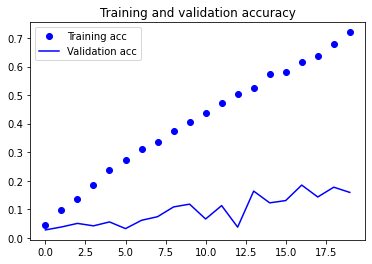

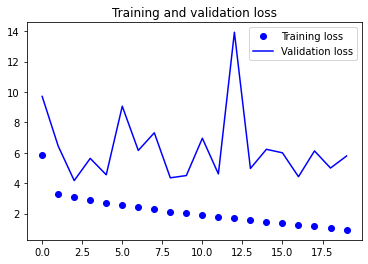

In [13]:
# 학습 과정의 accuracy와 loss 값을 plot
import matplotlib.pyplot as plt

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [14]:
model.evaluate(test_data, steps=1750//50)

35/35 [==============================] - 12s 339ms/step - loss: 5.8056 - accuracy: 0.1611


[5.805617332458496, 0.16114285588264465]